## From http://www.cnblogs.com/foley/p/5582358.html

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pylab as plt

In [2]:
def parse(x):
    return datetime.strptime(x, '%Y/%m/%d')

data = pd.read_csv('AirPassengers.csv', parse_dates=[0], index_col=0, date_parser=parse)
data.head()

,NumPassengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [3]:
ts = data['NumPassengers']

## 稳定性检验  
大数定理和中心定理中要求样本同分布（这里同分布等价于时间序列中的平稳性），而我们的建模过程中有很多都是建立在大数定理和中心极限定理的前提条件下的，如果它不满足，得到的许多结论都是不可靠的。以虚假回归为例，当响应变量和输入变量都平稳时，我们用t统计量检验标准化系数的显著性。而当响应变量和输入变量不平稳时，其标准化系数不在满足t分布，这时再用t检验来进行显著性分析，导致拒绝原假设的概率增加，即容易犯第一类错误  

宽平稳也叫弱平稳或者二阶平稳（均值和方差平稳），它应满足：

1.常数均值  2.常数方差  3.常数自协方差

In [5]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [6]:
rolmean = ts.rolling(window=12, center=False).mean()
rol_weighted_mean = ts.ewm(span=12, ignore_na=False,adjust=True,min_periods=0).mean()
rolstd  = ts.rolling(window=12, center=False).std()

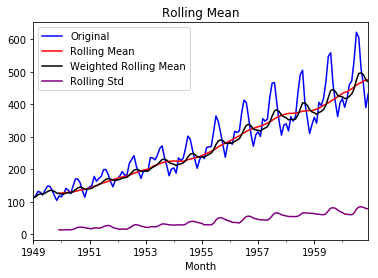

In [7]:
ts.plot(color='blue',label='Original')
rolmean.plot(color='red', label='Rolling Mean')
rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean')
rolstd.plot(color='purple', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean')
plt.show()

In [8]:
def testStationarity(ts):
    dftest = adfuller(ts)

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

In [9]:
testStationarity(ts)

Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (10%)            -2.578770
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
dtype: float64

ADF是一种常用的单位根检验方法，他的原假设为序列具有单位根，即非平稳，对于一个平稳的时序数据，就需要在给定的置信水平上显著，拒绝原假设。ADF只是单位根检验的方法之一，如果想采用其他检验方法，可以安装第三方包arch，里面提供了更加全面的单位根检验方法。检验结果其p值大于0.99，说明并不能拒绝原假设

In [10]:
def draw_acf_pacf(ts, lags=31):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts, lags=31, ax=ax1)
    ax2 = f.add_subplot(212)
    plot_pacf(ts, lags=31, ax=ax2)
    plt.show()

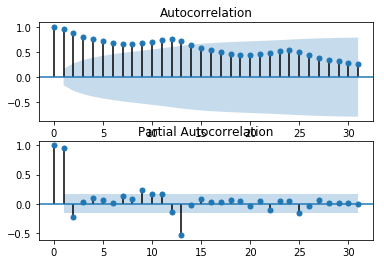

In [11]:
#具有年周期成分和长期趋势成分。平稳序列的自相关系数会快速衰减，下面的自相关图并不能体现出该特征，所以我们有理由相信该序列是不平稳的。
draw_acf_pacf(ts)

## 平稳性处理

### 1 对数变换  
对数变换主要是为了减小数据的振动幅度，使其线性规律更加明显。对数变换相当于增加了一个惩罚机制，数据越大其惩罚越大，数据越小惩罚越小。

In [13]:
ts_log = np.log(ts)
testStationarity(ts_log)

Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (10%)            -2.578770
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
dtype: float64

### 2 平滑法

窗口为12的移动平均能较好的剔除年周期性因素，而指数平均法是对周期内的数据进行了加权，能在一定程度上减小年周期因素，但并不能完全剔除，如要完全剔除可以进一步进行差分操作。

In [17]:
ts_weighted = ts_log.ewm(span=12, ignore_na=False,adjust=True,min_periods=0).mean()
testStationarity(ts_weighted)

Test Statistic                  -2.477357
p-value                          0.121081
#Lags Used                      14.000000
Number of Observations Used    129.000000
Critical Value (10%)            -2.578864
Critical Value (1%)             -3.482088
Critical Value (5%)             -2.884219
dtype: float64

### 3 差分法

经过12阶差分和1阶差分后，该序列满足平稳性的要求了。

In [18]:
diff_12 = ts_log.diff(12)
diff_12.dropna(inplace=True)
diff_12_1 = diff_12.diff(1)
diff_12_1.dropna(inplace=True)
testStationarity(diff_12_1)

Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (10%)            -2.580009
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
dtype: float64

### 4. 分解

statsmodels使用的X-11分解过程，它主要将时序数据分离成长期趋势、季节趋势和随机成分。 分解后的时序数据避免了他们在建模时的交叉影响，所以有助于预测准确性的提高。

In [21]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model="additive")

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

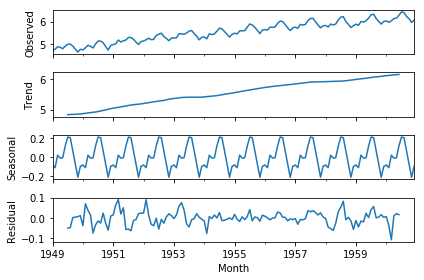

In [22]:
decomposition.plot()

In [24]:
testStationarity(residual.dropna())

Test Statistic                -6.332387e+00
p-value                        2.885059e-08
#Lags Used                     9.000000e+00
Number of Observations Used    1.220000e+02
Critical Value (10%)          -2.579569e+00
Critical Value (1%)           -3.485122e+00
Critical Value (5%)           -2.885538e+00
dtype: float64

Statistic值小于1%时的Critical value，所以在99%的置信度下，数据是稳定的

##  模型识别

In [17]:
rol_mean = ts_log.rolling(window=12).mean()
rol_mean.dropna(inplace=True)
ts_diff_1 = rol_mean.diff(1)
ts_diff_1.dropna(inplace=True)
testStationarity(ts_diff_1)

Test Statistic                  -2.709577
p-value                          0.072396
#Lags Used                      12.000000
Number of Observations Used    119.000000
Critical Value (1%)             -3.486535
Critical Value (5%)             -2.886151
Critical Value (10%)            -2.579896
dtype: float64

In [19]:
#在置信水平为95%的区间下并不显著，我们对其进行再次一阶差分  （12阶移动平均加上一阶差分与直接12阶差分是等价的关系，后者是前者数值的12倍）
ts_diff_2 = ts_diff_1.diff(1)
ts_diff_2.dropna(inplace=True)
testStationarity(ts_diff_2)

Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64

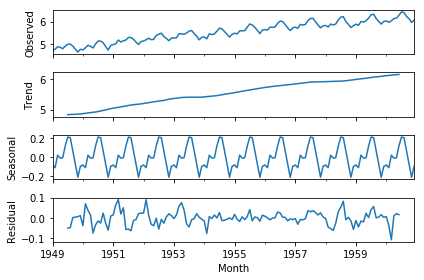

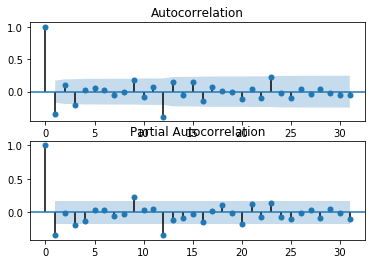

In [20]:
draw_acf_pacf(ts_diff_2)

发现自相关和偏相系数都存在拖尾的特点，并且他们都具有明显的一阶相关性，所以我们设定p=1, q=1。下面就可以使用ARMA模型进行数据拟合了

In [21]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(ts_diff_2, order=(1, 1)) 
result_arma = model.fit( disp=-1, method='css')

## 样本拟合

In [23]:
#预测值还原

predict_ts = result_arma.predict()
# 一阶差分还原
diff_shift_ts = ts_diff_1.shift(1)
diff_recover_1 = predict_ts.add(diff_shift_ts)
# 再次一阶差分还原
rol_shift_ts = rol_mean.shift(1)
diff_recover = diff_recover_1.add(rol_shift_ts)
# 移动平均还原
rol_sum = ts_log.rolling(window=11).sum()
rol_recover = diff_recover*12 - rol_sum.shift(1)
# 对数还原
log_recover = np.exp(rol_recover)
log_recover.dropna(inplace=True)

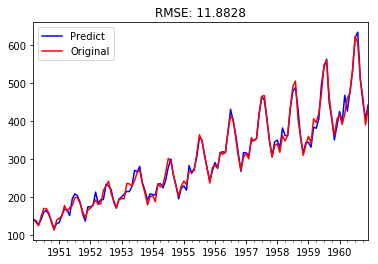

In [24]:
ts = ts[log_recover.index]  # 过滤没有预测的记录
plt.figure(facecolor='white')
log_recover.plot(color='blue', label='Predict')
ts.plot(color='red', label='Original')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((log_recover-ts)**2)/ts.size))
plt.show()

## Example for ARIMA模型 

In [36]:
from statsmodels.tsa.arima_model import ARIMA

In [43]:
ts_log_diff = ts_log - ts_log.shift()

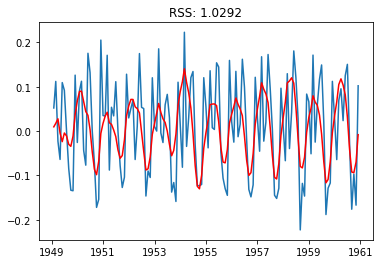

In [57]:
%matplotlib inline
model = ARIMA(ts_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff.dropna())**2))

In [65]:
class arima_model:

    def __init__(self, ts, maxLag=9):
        self.data_ts = ts
        self.resid_ts = None
        self.predict_ts = None
        self.maxLag = maxLag
        self.p = maxLag
        self.q = maxLag
        self.properModel = None
        self.bic = sys.maxsize

    # 计算最优ARIMA模型，将相关结果赋给相应属性
    def get_proper_model(self):
        self._proper_model()
        self.predict_ts = deepcopy(self.properModel.predict())
        self.resid_ts = deepcopy(self.properModel.resid)

    # 对于给定范围内的p,q计算拟合得最好的arima模型，这里是对差分好的数据进行拟合，故差分恒为0
    def _proper_model(self):
        for p in np.arange(self.maxLag):
            for q in np.arange(self.maxLag):
                # print p,q,self.bic
                model = ARMA(self.data_ts, order=(p, q))
                try:
                    results_ARMA = model.fit(disp=-1, method='css')
                except:
                    continue
                bic = results_ARMA.bic
                # print 'bic:',bic,'self.bic:',self.bic
                if bic < self.bic:
                    self.p = p
                    self.q = q
                    self.properModel = results_ARMA
                    self.bic = bic
                    self.resid_ts = deepcopy(self.properModel.resid)
                    self.predict_ts = self.properModel.predict()

    # 参数确定模型
    def certain_model(self, p, q):
            model = ARMA(self.data_ts, order=(p, q))
            try:
                self.properModel = model.fit( disp=-1, method='css')
                self.p = p
                self.q = q
                self.bic = self.properModel.bic
                self.predict_ts = self.properModel.predict()
                self.resid_ts = deepcopy(self.properModel.resid)
            except:
                print ('You can not fit the model with this parameter p,q, ' \
                      'please use the get_proper_model method to get the best model')

In [67]:
model = arima_model(ts_diff_2)
model.get_proper_model()
print ('bic:', model.bic, 'p:', model.p, 'q:', model.q)

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels

C:\Anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda\lib\site-packages\

bic: -1090.44209358 p: 0 q: 1


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
